In [11]:
import sys
sys.path.append("../code/")
from common import APPLIANCES_ORDER
import tflearn
import tensorflow as tf



In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
tensor = np.load('../1H-input.npy')

In [14]:
def create_subset_dataset(tensor):
    t_subset = tensor[:, :, 180:194, :]
    all_indices = np.array(list(range(320)))
    for i in range(1, 7):
        valid_homes = pd.DataFrame(t_subset[:, i, :].reshape(320, 14*24)).dropna().index
        all_indices = np.intersect1d(all_indices, valid_homes)
    t_subset = t_subset[all_indices, :, :, :].reshape(52, 7, 14*24)
    
    # Create artificial aggregate
    t_subset[:, 0, :] = 0.0
    for i in range(1, 7):
        t_subset[:, 0, :] = t_subset[:, 0, :] + t_subset[:, i, :]
    # t_subset is of shape (#home, appliance, days*hours)
    return t_subset, all_indices

In [15]:
t_all, valid_homes = create_subset_dataset(tensor)
t_all.shape

(52, 7, 336)

In [16]:
t_all.shape

(52, 7, 336)

In [114]:
def my_objective(y_pred, y_true):
    with tf.name_scope(None):
        return tf.losses.absolute_difference(y_pred, y_true)

In [142]:
#pred = {}
# Predict HVAC using Aggregate data. No RNN for now.

tf.reset_default_graph()
print("*"*80)
train_all = t_all[:20, :, :]
validation_all = t_all[20:30, :, :]
test_all = t_all[30:, :, :]
train_agg = train_all[:, 0, :]
train_appliance = train_all[:, 1:, :].reshape(20, 336*6)
validation_agg = validation_all[:, 0, :]
validation_appliance = validation_all[:, 1:, :].reshape(10, 336*6)

net = tflearn.input_data(shape=[None, 336])
net = tflearn.fully_connected(net, 400, activation='relu')
net = tflearn.dropout(net, 0.6)
net = tflearn.fully_connected(net, 600, activation='relu')


net = tflearn.dropout(net, 0.6)
net = tflearn.fully_connected(net, 6000, activation='relu')



net = tflearn.dropout(net, 0.6)



net = tflearn.fully_connected(net, 8000, activation='relu')
net = tflearn.dropout(net, 0.6)

net = tflearn.fully_connected(net, 9000, activation='relu')
net = tflearn.dropout(net, 0.6)

net = tflearn.fully_connected(net, 6000, activation='relu')
net = tflearn.dropout(net, 0.6)


#net = tflearn.fully_connected(net, 336)
net = tflearn.fully_connected(net, 6*336, activation='linear')
net = tflearn.regression(net, loss=my_objective, learning_rate=1e-3, )
#tflearn.lstm()
model = tflearn.DNN(net, )
# Start training (apply gradient descent algorithm)
model.fit(train_agg ,train_appliance, n_epoch=50, batch_size=20, show_metric=True, 
      validation_set=(validation_agg, validation_appliance))


********************************************************************************
---------------------------------
Run id: VQJC7P
Log directory: /tmp/tflearn_logs/
INFO:tensorflow:Summary name Accuracy/ (raw) is illegal; using Accuracy/__raw_ instead.
---------------------------------
Training samples: 20
Validation samples: 10
--
Training Step: 1  | time: 2.525s
| Adam | epoch: 001 | loss: 0.00000 - acc: 0.0000 | val_loss: 162.15775 - val_acc: 0.0000 -- iter: 20/20
--
Training Step: 2  | total loss: 256.21811 | time: 2.225s
| Adam | epoch: 002 | loss: 256.21811 - acc: 0.0000 | val_loss: 157.35010 - val_acc: 0.0000 -- iter: 20/20
--
Training Step: 3  | total loss: 208.52032 | time: 2.171s
| Adam | epoch: 003 | loss: 208.52032 - acc: 0.0000 | val_loss: 155.41965 - val_acc: 0.0000 -- iter: 20/20
--
Training Step: 4  | total loss: 177.36911 | time: 2.157s
| Adam | epoch: 004 | loss: 177.36911 - acc: 0.0375 | val_loss: 143.29454 - val_acc: 0.0000 -- iter: 20/20
--
Training Step: 5  | total

Training Step: 44  | total loss: 102.44094 | time: 2.211s
| Adam | epoch: 044 | loss: 102.44094 - acc: 0.0263 | val_loss: 114.87621 - val_acc: 0.0000 -- iter: 20/20
--
Training Step: 45  | total loss: 102.98904 | time: 2.125s
| Adam | epoch: 045 | loss: 102.98904 - acc: 0.0303 | val_loss: 115.42394 - val_acc: 0.0000 -- iter: 20/20
--
Training Step: 46  | total loss: 102.10550 | time: 2.113s
| Adam | epoch: 046 | loss: 102.10550 - acc: 0.0253 | val_loss: 105.34701 - val_acc: 0.1000 -- iter: 20/20
--
Training Step: 47  | total loss: 102.16998 | time: 2.126s
| Adam | epoch: 047 | loss: 102.16998 - acc: 0.0375 | val_loss: 107.93539 - val_acc: 0.1000 -- iter: 20/20
--
Training Step: 48  | total loss: 101.48646 | time: 2.156s
| Adam | epoch: 048 | loss: 101.48646 - acc: 0.0395 | val_loss: 123.24606 - val_acc: 0.1000 -- iter: 20/20
--
Training Step: 49  | total loss: 101.31780 | time: 2.149s
| Adam | epoch: 049 | loss: 101.31780 - acc: 0.0412 | val_loss: 116.26148 - val_acc: 0.1000 -- iter: 2

In [153]:
pred = {}
pred_overall= model.predict(test_all[:, 0, :]).reshape(22, 6, 336)
for i, appliance in enumerate(APPLIANCES_ORDER[1:]):
    pred[appliance] = pred_overall[:, i, :]
    pred[appliance][pred[appliance]<0.] = 0.
    pred[appliance][pred[appliance]>test_all[:, 0, :]] = test_all[:, 0, :][pred[appliance]>test_all[:, 0, :]]

In [154]:
np.allclose(pd.DataFrame(train_appliance).values.reshape(20, 6, 336), train_all[:, 1:, :])

True

In [155]:
pred.reshape(22, )

AttributeError: 'dict' object has no attribute 'reshape'

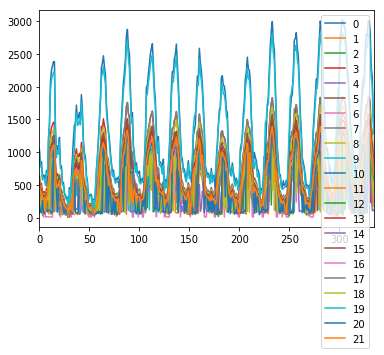

In [156]:
pd.DataFrame(pred['hvac']).T.plot()

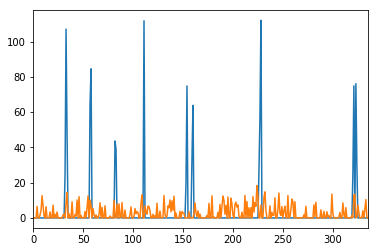

In [157]:
#pd.Series(test_all[21, 0, :]).plot()
appliance="wm"
appliance_num = APPLIANCES_ORDER.index(appliance)
home = 0
pd.Series(test_all[home, appliance_num, :]).plot()


pd.Series(pred[appliance][home, :]).plot()

In [158]:
gt = tensor[valid_homes, :, 180:194, :][30:, :, :, :].reshape(22, 7, 336)

In [159]:
err = {}
for appliance in APPLIANCES_ORDER[1:]:
    appliance_num = APPLIANCES_ORDER.index(appliance)
    x = pred[appliance]
    x[x<0.] = 0.
    err[appliance] = np.abs(x-gt[:,appliance_num,:]).mean()
err

{'dw': 18.20616693073935,
 'fridge': 39.857332643076127,
 'hvac': 396.64220145165274,
 'mw': 8.4038905734016147,
 'oven': 21.31223434810008,
 'wm': 8.9579758694718219}

In [150]:
err = {}
for appliance in APPLIANCES_ORDER[1:]:
    appliance_num = APPLIANCES_ORDER.index(appliance)
    x = pred[appliance]
    x[x<0.] = 0.
    err[appliance] = np.abs(x-gt[:,appliance_num,:]).mean()
err

{'dw': 18.212301002711296,
 'fridge': 40.645920549671558,
 'hvac': 462.12592043461092,
 'mw': 8.409175865491374,
 'oven': 21.318583407123466,
 'wm': 8.9652534917102038}

<tf.Tensor 'read:0' shape=(336, 336) dtype=float32>

In [66]:
pd.Series(err)

dw         24.501916
fridge     40.642623
hvac      407.645032
mw          9.477331
oven       24.559614
wm          9.269064
dtype: float64

In [44]:
err = {}
for appliance in APPLIANCES_ORDER[1:]:
    appliance_num = APPLIANCES_ORDER.index(appliance)
    x = pred[appliance]
    x[x<0.] = 0.
    err[appliance] = np.abs(x-gt[:,appliance_num,:]).mean()
err

{'dw': 24.870927145657255,
 'fridge': 40.642622669315109,
 'hvac': 407.64503194612212,
 'mw': 9.5177636509070478,
 'oven': 24.630917072655215,
 'wm': 9.4858786798710284}

In [46]:
pd.Series(err).mean()

86.13219019408797

In [50]:
(pd.DataFrame(pred['hvac'])-pd.DataFrame(gt[:,1,:])).abs().sum(axis=1)

0      76795.709343
1      90376.204248
2     107125.516512
3     154093.437996
4      75034.047701
5     112149.631845
6     161112.576504
7     126881.272907
8     125538.213085
9     189063.335770
10    215992.330513
11    205689.315586
12    214037.400083
13     88024.450001
14     88011.922891
15    162560.397587
16    102536.124285
17     76096.244452
18    194650.624890
19    126364.546612
20    210910.802409
21    110267.970926
dtype: float64

In [495]:
pd.DataFrame(err_sc).min(axis=1)

dw        98.465801
fridge    65.367590
hvac      76.061186
mw        69.195618
oven      59.718504
wm        50.857821
dtype: float64

In [51]:
def accuracy_pie_chart(ground_truth_appliance, prediction_appliance, gt_aggregate):
    out = 0.
    for i in range(6):
        out = out + min(np.sum(ground_truth_appliance[:, i, :]), np.sum(prediction_appliance[:, i, :]))
    return out/np.sum(gt_aggregate)    

In [55]:
approach_pred = {'Neural':pred}

pie_accuracies = {}
for approach_name, approach_prediction in approach_pred.items():
    pie_accuracies[approach_name] = accuracy_pie_chart(gt, approach_prediction, test_all[:, 0, :])

TypeError: unhashable type: 'slice'

Text(0,0.5,'Pie-chart energy breakdown \nproportion correctly identified\n(Higher is better)')

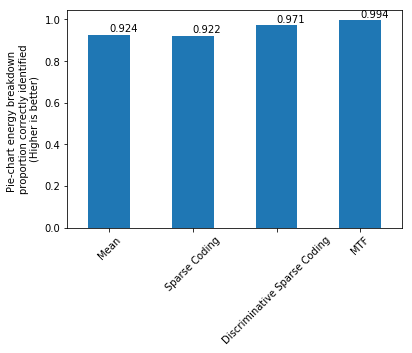

In [526]:
pie_accuracies = pd.Series(pie_accuracies).loc[['Mean','Sparse Coding','Discriminative Sparse Coding','MTF']]
ax = pie_accuracies.plot(kind='bar',rot=45)
for i, v in enumerate(pie_accuracies):
    ax.text( i,v+0.03, str(v.round(3)), va='center')
plt.ylabel("Pie-chart energy breakdown \nproportion correctly identified\n(Higher is better)")

In [522]:
pd.Series(pie_accuracies).

Discriminative Sparse Coding    0.971380
MTF                             0.994402
Mean                            0.923875
Sparse Coding                   0.921797
dtype: float64

In [487]:
mean_pred = np.zeros_like(pred_mtf)
mean_pred[:, :, :] = train_data.mean(axis=2)

In [488]:
mean_pred.shape

(22, 6, 336)

In [490]:
err_mean

{'dw': 101.42720929364509,
 'fridge': 76.717538971029512,
 'hvac': 78.719166409204803,
 'mw': 72.453527550654172,
 'oven': 65.686567624501521,
 'wm': 73.401499222720375}